# Computational Finance

## Lab Assignment 1

Authors:
- Kevin de Vries
- Jed Boyle
- Krishnakanth Sasi

Student numbers:
- 10579869
- 00000000
- 11391952

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Part 1: Option valuation

In [328]:
def payoff(S,K,call):
    '''
    Calculates the payoff of an option layer
    '''
    
    f = S - K if call else K - S
    f[f < 0] = 0
    return f

def option_valuation(S0,K,T,N,r,v,call=True,american=False):
    '''
    Calculates the option valuation from a given node.
    
    Parameters
        S0: float
            Current stock price
        K: float
            Strike price
        T: float
            Maturity of the option
        N: int
            Number of time steps
        r: float
            Interest rate
        v: float
            Volatility
        call: Bool
            Determines if option is a call or a put
        american: Bool
            Determines if option is American of European
        
    Returns
        f: float
            Option valuation
        delta: float
            Hedge parameter
    '''
    
    # Time step length
    dt = T / N
    
    # Calculate tree parameters
    u = np.exp(v * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)

    # Stock prices at expiration
    S = S0 * u**(np.arange(0,N+1) - np.arange(0,N+1)[::-1])
    
    # Call option value at expiration
    f = payoff(S,K,call)
    
    for i in range(N-1):
        f = np.exp(-r*dt) * (p*f[1:N-i+1] + (1-p)*f[0:N-i])
        
        # American option can be exercised before maturity.
        # The highest possible payoff per node is thus considered risk neutral.
        if american:
            S = S0 * u**(np.arange(0,N-i) - np.arange(0,N-i)[::-1])
            f_potential = payoff(S,K,call)
            f = np.maximum(f,f_potential)
            
    delta = (f[1]-f[0]) / (S0*(u-d))
    f = np.exp(-r*dt) * (p*f[1] + (1-p)*f[0])
    
    return f, delta

# Black Scholes formula

def black_scholes(r, K, T, S_0, sigma):
    '''
    Calculates the Hedge ratio, call price and put price
    
    Parameters
        r: float
            Interest rate
        K: float
            Strike price
        T: int
            Time of maturity
        S_0: float
            Current stock price
        sigma: float
            Volatility
        
    Returns
        N1: float
            Hedge ratio
        c: float
            Call price
        p: float
            Put price
    '''
    d1 = (np.log(S_0/K)+(r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1-sigma*(T**0.5) 
    N1 = norm.cdf(d1)
    N2 = norm.cdf(d2)
    N3 = norm.cdf(-d1)
    N4 = norm.cdf(-d2)
    c = S_0*N1 - K*math.exp(-r*T)*N2
    p = K*np.exp(-r*T)*N4 - S_0*N3
    return N1, c, p 

In [334]:
# Test option valuation on the example in the slides

f,delta = option_valuation(50,50,5/12,5,0.1,0.4,call=False)
print(f)
print(delta)

4.31901871652
-0.393051801205


In [335]:
# Test option valuation on the initial parameters in the assignment
# Analytical value of valuation was supposedly ~11.4 according to the lecturer

cur, strike = 100.0, 99
volatility, interest = 0.2, 0.06
maturity, steps = 1, 50

f,delta = option_valuation(cur,strike,maturity,steps,interest,volatility)

print(f)
print(delta)

11.5464348508
0.672556964605


In [336]:
# Test option valuation on the initial parameters in the assignment using American option

cur, strike = 100.0, 99.0
volatility, interest = 0.2, 0.06
maturity, steps = 1, 50

f,delta = option_valuation(cur,strike,maturity,steps,interest,volatility,call=False,american=True)

print(f)
print(delta)

5.34776349842
-0.382039156259


In [338]:
r = 0.06 # interest rate
K = 99 # strike price
T = 1 # time of maturity
S_0 = 100 # current stock price
sigma = 0.2 # volatility

hedgeRatio, callPrice, putPrice =  black_scholes(r, K, T, S_0, sigma) #returns the analytic values 

print("Hedge ratio is %f" % hedgeRatio)
print("Call price is %f" % callPrice)

Hedge ratio is 0.673736
Call price is 11.544280


# Part 2: Hedging Simulations

In [339]:
# def stock_price(S_0, N, r = .06, sigma = .2, T = 1):
#     delta_t = T / N
#     S = np.zeros(N)
#     dZ = np.sqrt(delta_t) * np.random.normal(0,1,N)
#     S[0] = S_0
#     for i in range(1, N):
#         S[i] = S[i-1] + r * S[i-1] * delta_t + sigma * S[i-1] * dZ[i]
    
#     return S

# def hedge_ratios(S, N, r = .06, sigma = .2, K = 99, T = 1):
#     T_i = T - T / N * np.arange(N)
#     d1 = np.log(S[:N]/K) + T_i * (r + ((sigma**2) /2)) / (sigma * np.sqrt(T_i))
#     hedge_ratios = norm.cdf(d1)
#     return hedge_ratios


# def dynamic_hedging(S, deltas, N, r = .06, sigma = .2, K = 99, T = 1):
    
#     dt = T / N
#     b = np.zeros(N+1)
    
#     _,c,_ = blackScholes(r, K, T, S[0], sigma)
    
#     b[0] = c - deltas[0]*S[0]
#     for i in range(1,N):
#         b[i] = np.exp(r*dt) * b[i-1] - (deltas[i] - deltas[i-1]) * S[i]
    
#     b[N] = np.exp(r*dt) * b[N-1] + deltas[N-1] * S[N] - max(0, S[N] - K)
#     return b



In [329]:
def stock_price(S_0, N, r = .06, sigma = .2, T = 1):
    delta_t = T / N
    S = np.zeros(N)
    dZ = np.sqrt(delta_t) * np.random.normal(0,1,N)
    S[0] = S_0
    for i in range(1, N):
        S[i] = S[i-1] + r * S[i-1] * delta_t + sigma * S[i-1] * dZ[i]
    
    return S

# Useful literature:
# https://esc.fnwi.uva.nl/thesis/centraal/files/f1843690389.pdf
def dynamic_hedging_simulation(S_0 = 100, N = 52, T = 1, r = .06, K = 99, stock_sigma = .2, valuation_sigma =.2):
    dt = T/N
    
    # S := stock price.  
    S = stock_price(S_0, N, r, stock_sigma, T)
    # deltas := hedging ratios. 
    deltas = np.zeros(N)
    # balances := cash loan required in hedge position.
    balances = np.zeros(N)
    # options := Black-Scholes valuation of the loan.
    options = np.zeros(N)
    
    deltas[0], options[0], _ = black_scholes(r, K, T, S[0], valuation_sigma)
    balances[0] = options[0] - deltas[0]*S[0]
    for i in range(1, N):
        deltas[i], options[i], _ = black_scholes(r, K, T - i*dt, S[i], valuation_sigma)
        balances[i] = np.exp(r*dt) * balances[i-1] - (deltas[i] - deltas[i-1]) * S[i]
    
    # hedge_portfolio := value of hedge portfolio.
    hedge_portfolio = deltas * S + balances
    hedge_error = (hedge_portfolio[N-1] - max(0, S[N-1]-K))
    
    return hedge_error, hedge_portfolio, balances, options, deltas, S 


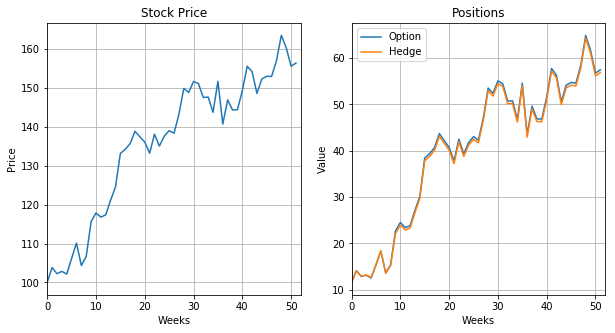

In [330]:
hedge_error, hedge_portfolio, balances, options, deltas, S  = dynamic_hedging_simulation()

plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(52), S)
plt.xlim(0,52)
plt.grid()
plt.title('Stock Price')
plt.ylabel('Price')
plt.xlabel('Weeks')
plt.subplot(1, 2, 2)
plt.plot(range(52), options, label='Option')
plt.plot(range(52), hedge_portfolio, label='Hedge')
plt.legend()
plt.xlim(0, 52)
plt.grid()
plt.title('Positions')
plt.ylabel('Value')
plt.xlabel('Weeks')
plt.show()

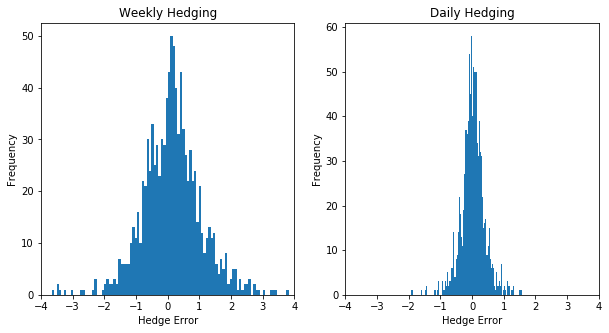

In [331]:
num_simulations = 1000

N = 52
weekly_hedging = np.array([
    dynamic_hedging_simulation(N = N)[0] for i in range(num_simulations)
])

N = 365
daily_hedging = np.array([
    dynamic_hedging_simulation(N = N)[0] for i in range(num_simulations)
])

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.hist(weekly_hedging, 100)
plt.xlim(-4,4)
plt.title('Weekly Hedging')
plt.ylabel('Frequency')
plt.xlabel('Hedge Error')
plt.subplot(1, 2, 2)
plt.hist(daily_hedging, 100)
plt.xlim(-4,4)
plt.title('Daily Hedging')
plt.ylabel('Frequency')
plt.xlabel('Hedge Error')
plt.show()

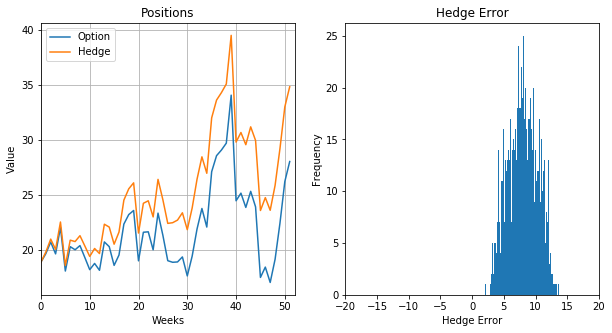

In [332]:
num_simulations = 1000
stock_sigma = .2
valuation_sigma = .4

_, hedge_portfolio, _, options, _, _  = dynamic_hedging_simulation(
                                        stock_sigma = stock_sigma, 
                                        valuation_sigma =valuation_sigma)

N = 52
weekly_hedging = np.array([
    dynamic_hedging_simulation(stock_sigma = stock_sigma, 
                               valuation_sigma = valuation_sigma)[0] 
    for i in range(num_simulations)
])

plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(52), options, label='Option')
plt.plot(range(52), hedge_portfolio, label='Hedge')
plt.legend()
plt.xlim(0, 52)
plt.grid()
plt.title('Positions')
plt.ylabel('Value')
plt.xlabel('Weeks')
plt.subplot(1, 2, 2)
plt.hist(weekly_hedging, 100)
plt.xlim(-20, 20)
plt.title('Hedge Error')
plt.ylabel('Frequency')
plt.xlabel('Hedge Error')
plt.show()

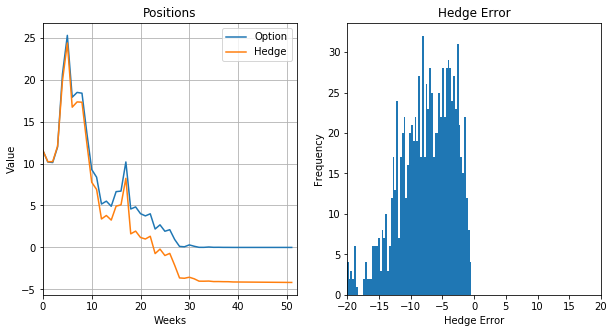

In [333]:
num_simulations = 1000
stock_sigma = .4
valuation_sigma = .2

_, hedge_portfolio, _, options, _, _  = dynamic_hedging_simulation(
                                        stock_sigma = stock_sigma, 
                                        valuation_sigma =valuation_sigma)

N = 52
weekly_hedging = np.array([
    dynamic_hedging_simulation(stock_sigma = stock_sigma, 
                               valuation_sigma = valuation_sigma)[0] 
    for i in range(num_simulations)
])

plt.show()
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(range(52), options, label='Option')
plt.plot(range(52), hedge_portfolio, label='Hedge')
plt.legend()
plt.xlim(0, 52)
plt.grid()
plt.title('Positions')
plt.ylabel('Value')
plt.xlabel('Weeks')
plt.subplot(1, 2, 2)
plt.hist(weekly_hedging, 100)
plt.xlim(-20, 20)
plt.title('Hedge Error')
plt.ylabel('Frequency')
plt.xlabel('Hedge Error')
plt.show()